# OCR remove background noise and draw regions
## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [ ]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
%pip install spark-ocr==$version --user --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
# or install from local path
# %pip install --user ../dist/spark-ocr-[version].tar.gz
%pip install termcolor

## Initialization of spark session

In [1]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

## Imports

In [2]:
from termcolor import colored

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image
from sparkocr.metrics import score

## Define OCR pipeline

In [10]:
# Read binary as image
pdf_to_image = PdfToImage()
pdf_to_image.setInputCol("content")
pdf_to_image.setOutputCol("image")
pdf_to_image.setResolution(400)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(91)
binarizer.setOffset(50)

# Apply morphology opening
opening = ImageMorphologyOperation()
opening.setKernelShape(KernelShape.SQUARE)
opening.setKernelSize(3)
opening.setInputCol("binarized_image")
opening.setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("opening_image")
remove_objects.setOutputCol("corrected_image")
remove_objects.setMinSizeObject(130)

# Image Layout Analyzer for detect regions
image_layout_analyzer = ImageLayoutAnalyzer()
image_layout_analyzer.setInputCol("corrected_image")
image_layout_analyzer.setOutputCol("region")
#image_layout_analyzer.setPageSegMode(PageSegmentationMode.SPARSE_TEXT)

draw_regions = ImageDrawRegions()
draw_regions.setInputCol("corrected_image")
draw_regions.setInputRegionsCol("region")
draw_regions.setOutputCol("image_with_regions")

# Run tesseract OCR for corrected image
ocr_corrected = ImageToText()
ocr_corrected.setInputCol("corrected_image")
ocr_corrected.setOutputCol("corrected_text")
ocr_corrected.setPositionsCol("corrected_positions")
ocr_corrected.setConfidenceThreshold(65)

# Run tesseract OCR for original image
ocr = ImageToText()
ocr.setInputCol("image")
ocr.setOutputCol("text")

# OCR pipeline
pipeline = PipelineModel(stages=[
    pdf_to_image,
    binarizer,
    opening,
    remove_objects,
    image_layout_analyzer,
    draw_regions,
    ocr,
    ocr_corrected
])

## Read image with noise

In [4]:
import pkg_resources
imagePath ='data/pdfs/noised.pdf'
image_df = spark.read.format("binaryFile").load(imagePath).cache()
image_df.show()

+--------------------+-------------------+-------+--------------------+
|                path|   modificationTime| length|             content|
+--------------------+-------------------+-------+--------------------+
|file:/Users/nmeln...|2020-01-13 07:52:52|2115939|[25 50 44 46 2D 3...|
+--------------------+-------------------+-------+--------------------+



## Run OCR pipelines

In [11]:
result = pipeline \
.transform(image_df) \
.cache()

## Results with original imge

In [6]:
grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("text")).alias("text"))
for row in grouped_results.collect():
    print(colored("Filename:\n%s , page: %d" % (row.path, row.pagenum), "red"))
    print("Recognized text:\n%s" % row.text)

Filename:
file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/pdfs/noised.pdf , page: 0
Recognized text:
 

Wels a Me a te ee a ' Date: . 1/36/68
Ce ES ota ~ Sample No. _ 5031 -. eae PTL ood :
“ Original request made by Mr. C. L. Tucker, Jr. ° on pa tot
Sample specifications written by _John H. M. Bohlken - 5
OI Be BON KER
, BLEND CASING RECASING ' FINAL FLAVOR MENTHOL FLAVOR
“OLD GOLD STRAIGHT Tobacco Blend : = a — " of
- Control. for Sample 1 No. 5030 at | 3 Ee a
*. Gigarettes: | ~
. Brana ------~-- OLD GOLD STRAIGHT
'. Length --------- 85 mm.
Circumference--~ 25.3 mn. o
Paper ~---------- Ecusta 556 ;
Firmness -----~- OLD GOLD STRAIGHT .
Draw -----~-+~-~-~-~~ OLD GOLD STRAIGHT | .,
Weight -------~- OLD GOLD STRAIGHT wrappings: .
Tipping Paper -- _ oa. , . .
abels ----
Print-----~----— OLD GOLD STRAIGHT slennneen Stongona STRAIGHT
C - Filter Length--- —-
~ _ Tear Tape-- Gold
. . Cartons --- OLD GOLD STRAIGHT
: =. Requirements: “ss 8 .. Markings-- Sample number on each
Ts 

## Results with corrected image

In [12]:
grouped_results = result.groupBy("path", "pagenum").agg(F.concat_ws("", F.collect_list("corrected_text")).alias("corrected_text"))
for row in grouped_results.collect():
    print(colored("Filename:\n%s , page: %d" % (row.path, row.pagenum), "red"))
    print("Recognized text:\n%s" % row.corrected_text)

Filename:
file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/pdfs/noised.pdf , page: 0
Recognized text:
° Date 7/16/68
Sanple No 5031

Original request mide by Mr ¢ GL Tucker Jr on 7/10/68
Sanple specifications written by John H M_Bohlten

en ee
BI END CASIIG RECASTIG FIIAL FIAVOR MF} [THOL FLAVOR

OLD GOLD STRAIGHT Tobacco Blend

Control for Sample ho 5030

Brand --------- OLD GOLD STRAIGHT
Length --------- 85 mm
Circumference-~-~ 25 3 mm
Paper wee ee ee Ecusta 556
Firmness -----+-. OLD GOLD STRAIGHT
Draw ---—---~+~~——.~ OLD GOLD STRAIGHT
Yoaght -~-------- OLD GOLD STRAIGHT Wrappings ,
Tipping Paper -- --
Print----------- OLD GOLD SIRAIGHT lens ___. OID GOLD STRAIGHT
C Filter Length--- __ osurec--- Standard Blue
~ Tear Tipe-- Gold
Cartons --- OLD GOLD STRAIGHT
Requiren nts _ Marhings-~- Sample number on each

Laboratory --- - one Tray pack and carton
Others ----~----

Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analy ces — JE CFE @ 

## ABBYY Lingvo results

In [8]:
abbyy = """-----
% Date: 7/16/68
X*: I; * • ■ Sample No. 5031___ — .*
•* Original request made by _____Mr. C. L. Tucker, Jr. on
Sample specifications written by
BLEND CASING RECASING
OLD GOLD STRAIGHT Tobacco Blend
Control for Sample No. 5030
John H. M. Bohlken
FINAL FLAVOR
) 7/10/68
MENTHOL FLAVOR
• Cigarettes; * . .v\ . /,*, *, S •
Brand --------- OLD GOLD STRAIGHT -V . ••••
; . L e n g t h ------- — 85 mm. . : '
Circumference-- 25.3 mm. • ' *;. • •
P a p e r ---------- Ecusta 556 • * .
F i r m n e s s---- —— OLD GOLD STRAIGHT . ! •■'
D r a w ___________ OLD GOLD STRAIGHT
W e i g h t --------- 0LD GOLD STRAIGHT Wrappings: « -
Tipping Paper — — *
p H n f —. — — _ _ ~ L a b e l s ----OLD GOLD STRAIGHT
( • Filter Length-- . — Closures--- Standard Blue .
^ ^ ; • Tear Tape— Gold
Cartons --- OLD GOLD STRAIGHT
s Requirements: . - •' • Markings-- Sample number on each
• pack and carton Laboratory----- One Tray .
O t h e r s --------- * , s • • . 4
Laboratory A n a l ysis^ I " '/***• * 7 ' ^ ^
Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — J-ZZ-Zf'- (£. / •
Responsibility;
Tobacco B l e n d ------Manufacturing - A. Kraus . . * -
Filter Production--- —
• Making & P a c k i n g---Product Development , John H. M. Bohlken
Shipping -----------
Reports:
t
Written by — John H. M. Bohlken
Original to - Mr. C. L. Tucker, Jr.
Copies t o ---Dr. A. W. Spears
• 9 ..
"""

## Display original and corrected images with regions

Original: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/pdfs/noised.pdf
Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/pdfs/noised.pdf 
        width: 3305
        height: 4677
        mode: 10


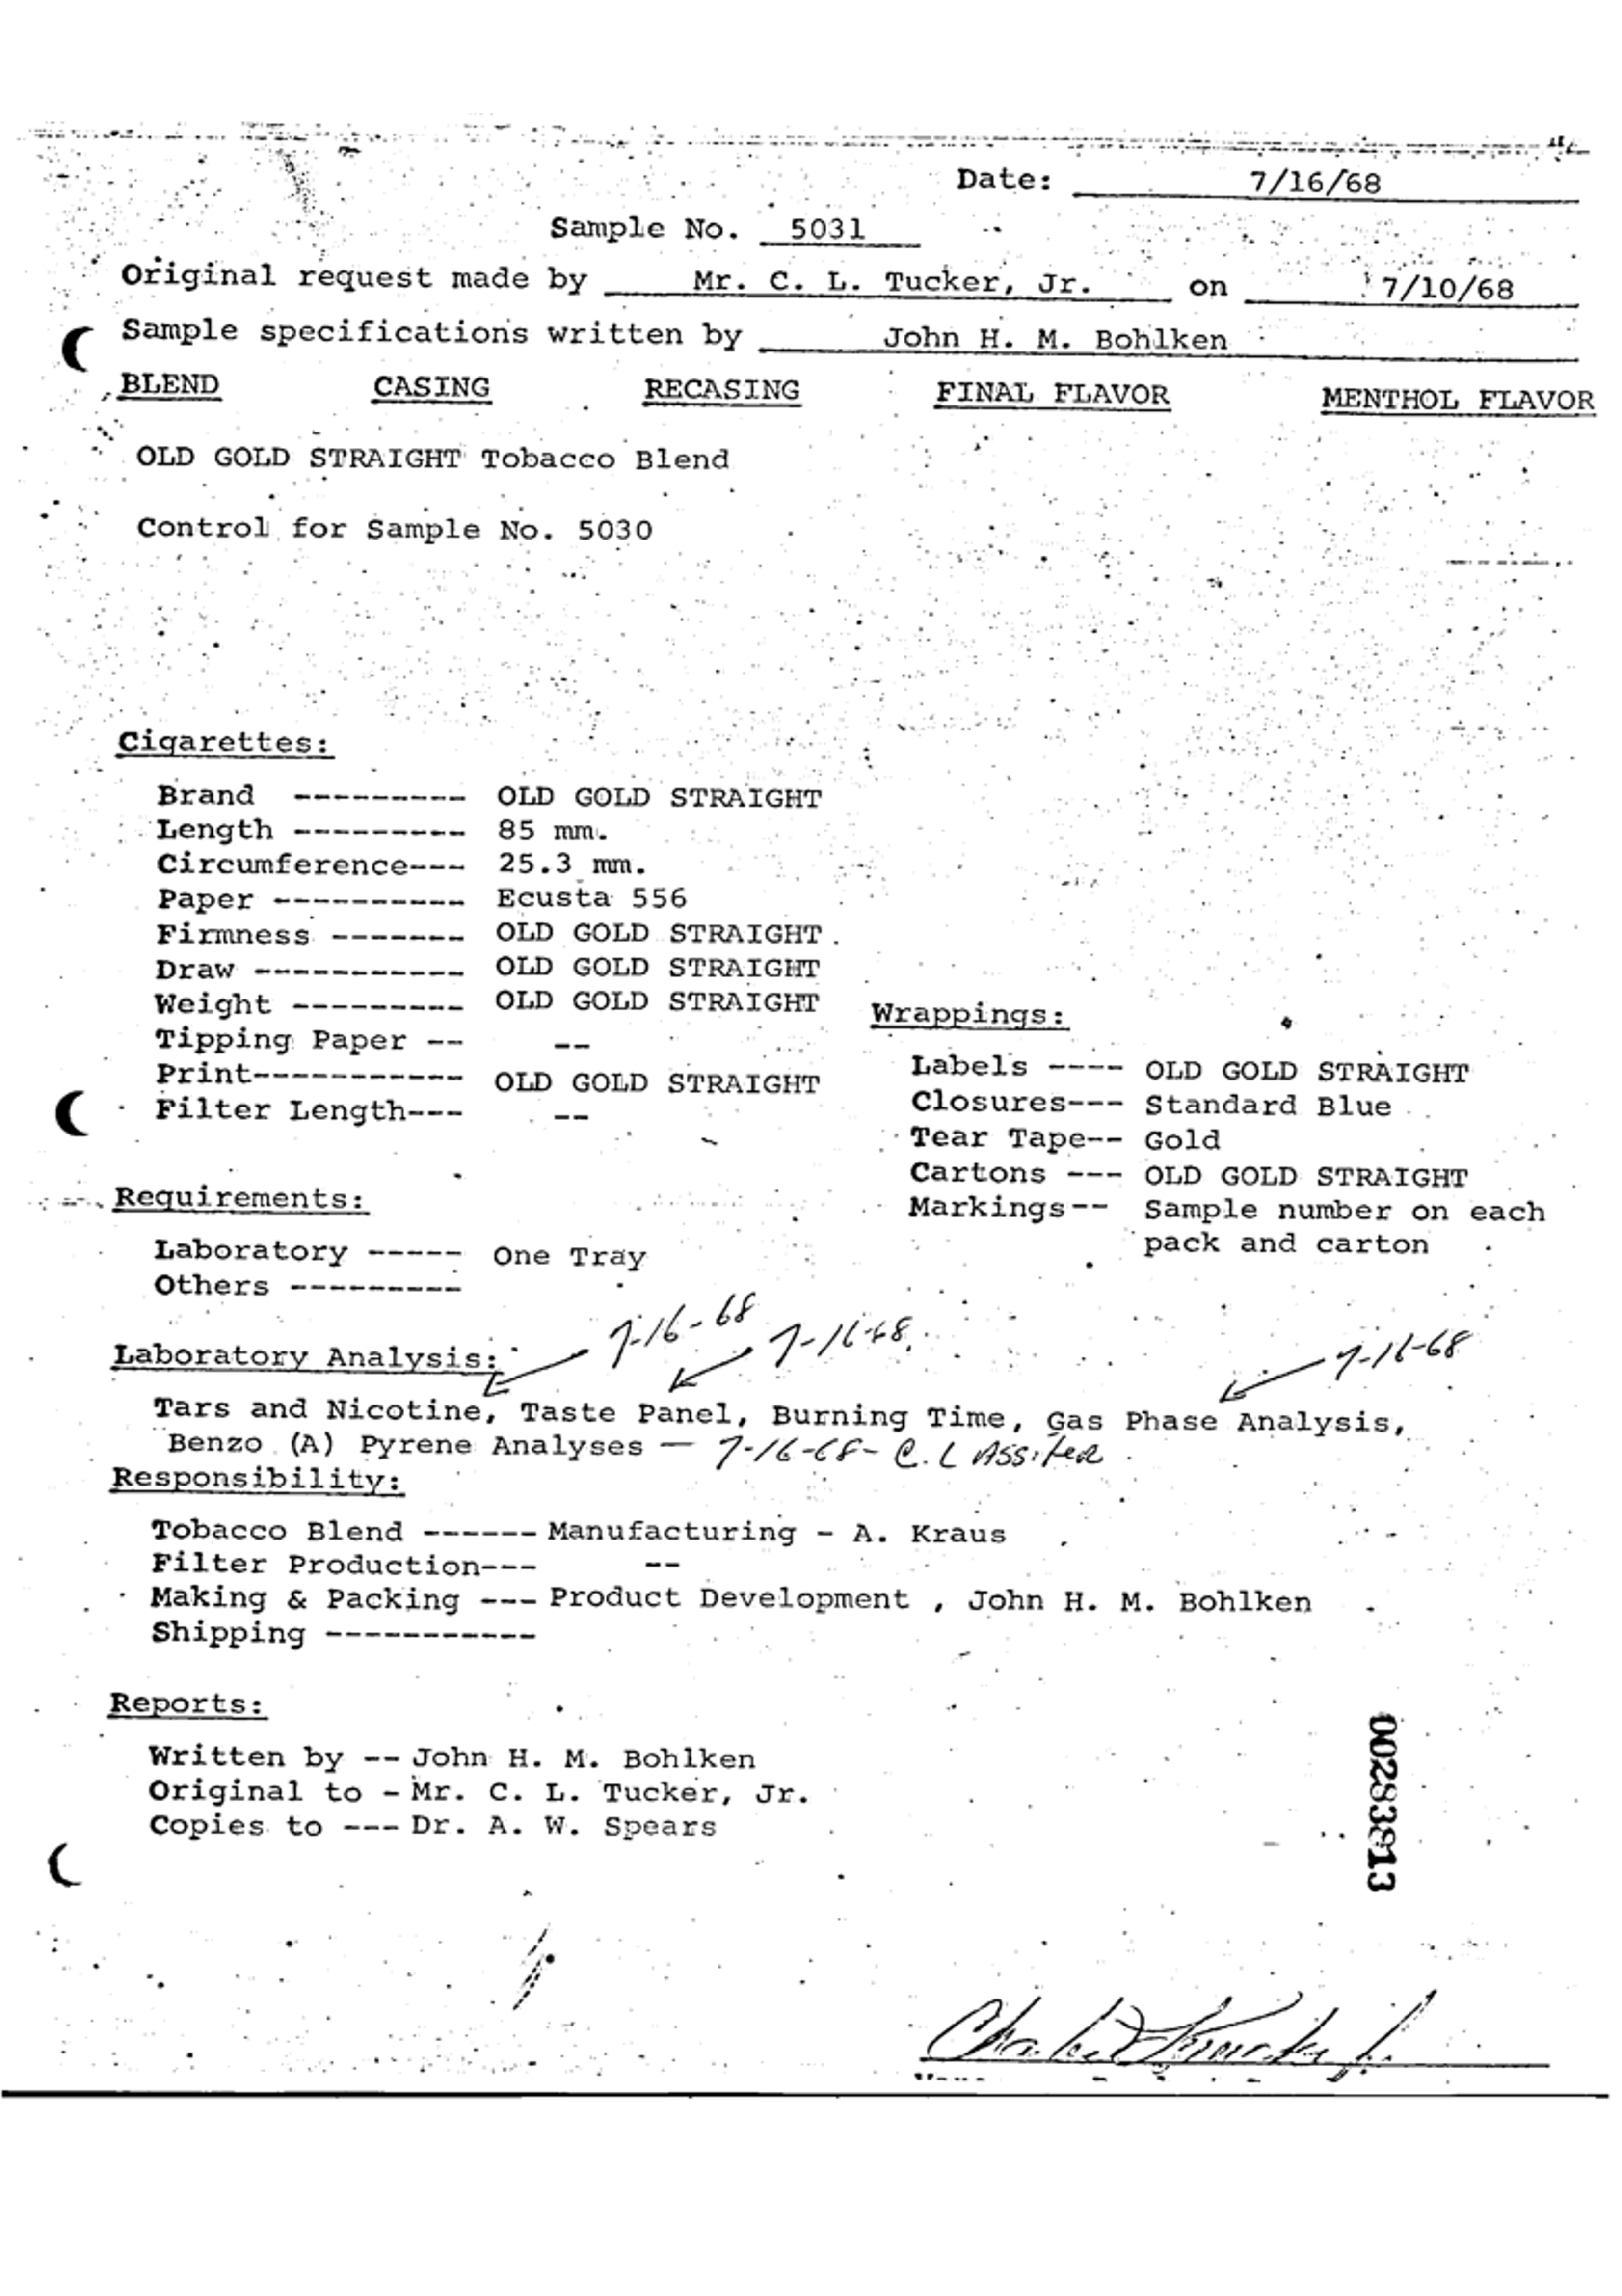

Corrected: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/pdfs/noised.pdf
Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/pdfs/noised.pdf 
        width: 3305
        height: 4677
        mode: 10


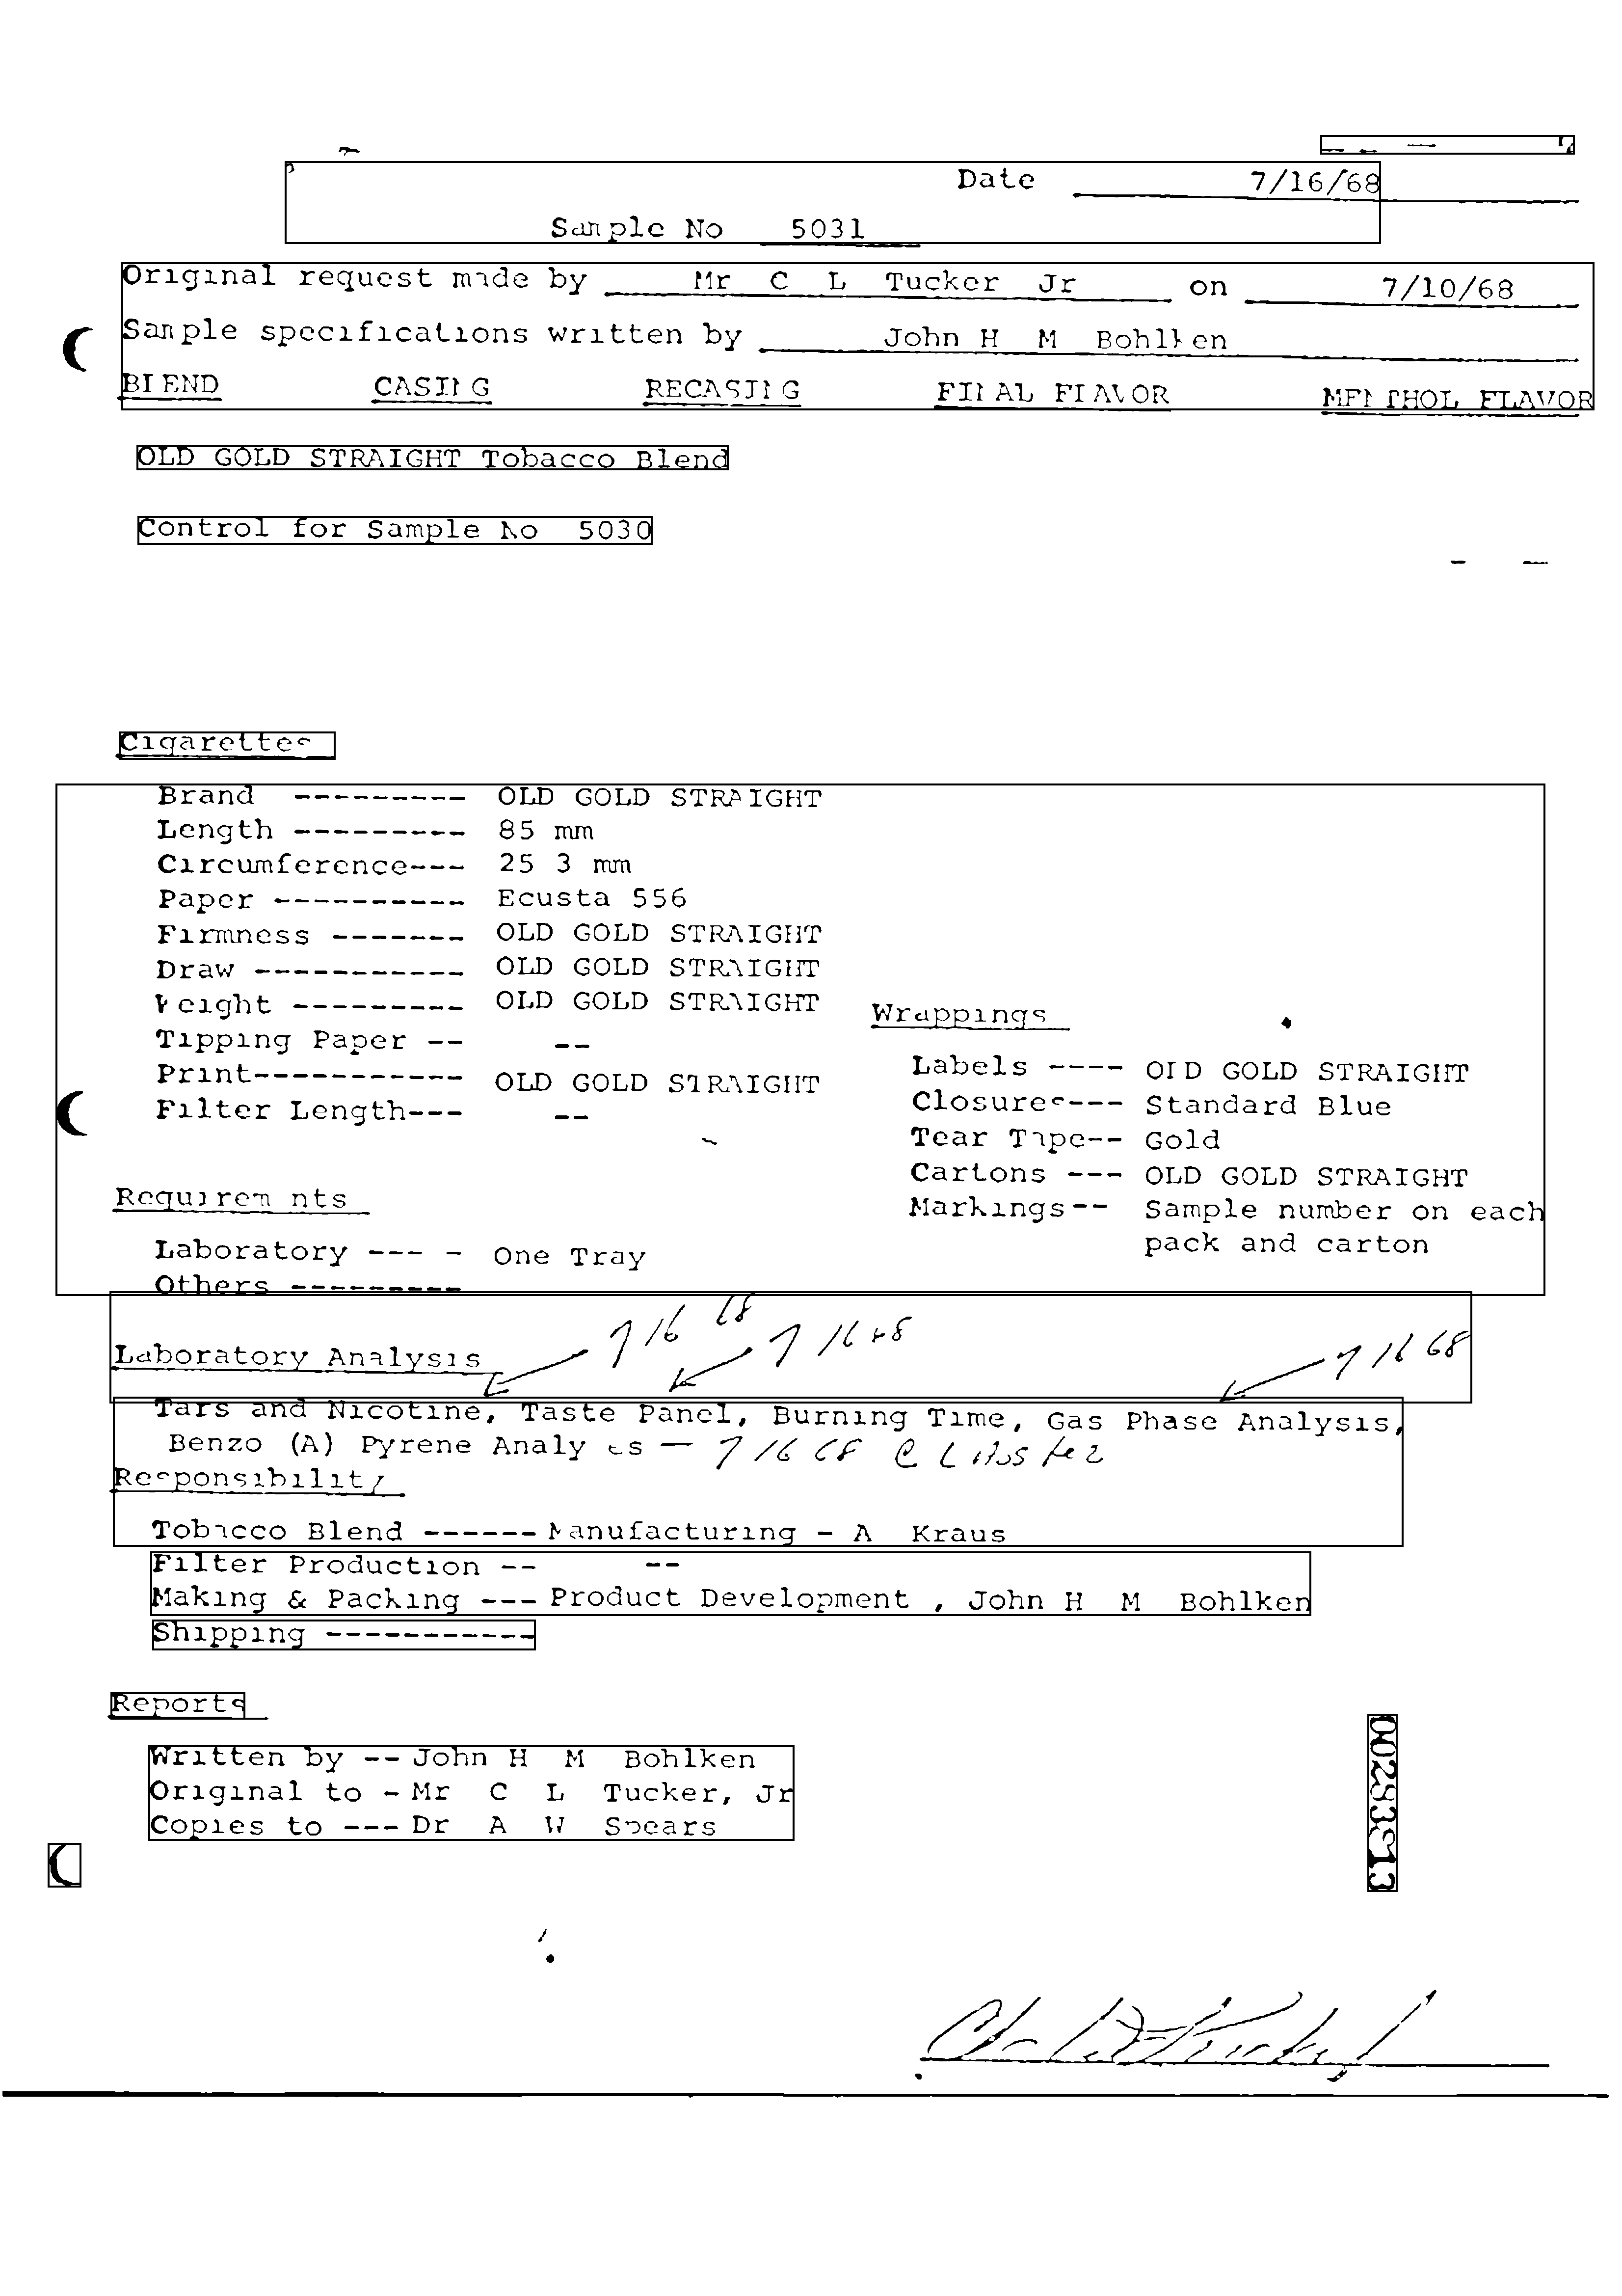

In [9]:
for r in result.select("path","image","image_with_regions").distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Corrected: %s" % r.path)
    display_image(r.image_with_regions)